# Import Libraries and Set Up Data

In [1]:
# import necessary libraries 
import pandas as pd
import tensorflow as tf
import os
import re
import numpy as np
from string import punctuation
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
# importing neural network libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, LSTM, RNN, SpatialDropout1D

## Turn Text Files into Pandas

In [0]:
def text2pandas(text):
    
    dataList = []
    article = [text[0]]
    
    for line in text[1:]:
        if not line.isspace():
            line = line.strip('\n')
            if line.startswith(" = ", 0):
                title = article[0].split(' = ')
                article[0] = title[1]
                article[1:] = [''.join(article[1:])] 
                dataList.append(article)
                article = []    
            
            elif line.startswith(" == ", 0):
                continue
                
            article.append(line)
         
    dataFrame = pd.DataFrame(dataList, columns = ['Title', 'Corpus']) 
    
    return dataFrame

In [0]:
# Import .txt files and convert to pandas DataFrames

with open("bio.fake.txt") as f:  
    data_fakes = f.readlines() 
    data_fakesPD = text2pandas(data_fakes)
    
with open("bio.test.txt") as f: 
    data_test = f.readlines() 
    data_testPD = text2pandas(data_test)
    
with open("bio.train.txt") as f: 
    data_train = f.readlines() 
    data_trainPD = text2pandas(data_train)
    
with open("bio.valid.txt") as f: 
    data_valid = f.readlines() 
    data_validPD = text2pandas(data_valid)

In [0]:
data_fakesPD['Label'] = 1

In [0]:
#Assign Labels
data_trainPD['Label'] = 0
data_validPD['Label'] = 0

In [0]:
#Concat reals and fakes
training_df = pd.concat([data_trainPD,data_fakesPD])

In [0]:
train_data = training_df.copy()
test_data = data_testPD.copy()

In [30]:
print(train_data.shape)
train_data.head()

(19300, 3)


,Title,Corpus,Label
0,\n,Alfonso ( Alphonsus ) Salmerón ( 8 September 1...,0
1,Cecil Reginald Burch,"Cecil Reginald Burch , FRS ( 12 May 1901 – 19 ...",0
2,Charles Claude Guthrie,"Charles Claude Guthrie ( September 26 , 1880 –...",0
3,Joachim Albertini,Joachim Albertini or Gioacchino Albertini ( 30...,0
4,Franklin Tanner Pember,"Franklin Tanner Pember ( November 2 , 1841 – A...",0


In [31]:
print(test_data.shape)
test_data.head()

(1001, 2)


,Title,Corpus
0,\n,Jan Krejčí ( 28 February 1825 Klatovy – 1 Augu...
1,Albert Ernest Radford,"Albert Ernest Radford ( January 25 , 1918 – Ap..."
2,Omar Saidou Tall,al-Hajj Omar Saidou Tall ( Umar ibn Sa'id al-F...
3,Paul Harteck,Paul Karl Maria Harteck ( 20 July 1902 – 22 Ja...
4,William John Tulloch,Prof William John Tulloch MD FRSE ( 1887–1966 ...


In [0]:
#Drop first line for now
validation_data = data_validPD.drop(data_validPD.index[0])
train_data = train_data.drop(train_data.index[0])
test_data = test_data.drop(test_data.index[0])

In [33]:
# checking for missing values
train_data.isnull().sum()

Title     0
Corpus    0
Label     0
dtype: int64

In [34]:
#Get the size of each article and add a column for it
length = []
[length.append(len(str(text))) for text in train_data['Corpus']]
train_data['Length'] = length
train_data.head()

,Title,Corpus,Label,Length
1,Cecil Reginald Burch,"Cecil Reginald Burch , FRS ( 12 May 1901 – 19 ...",0,942
2,Charles Claude Guthrie,"Charles Claude Guthrie ( September 26 , 1880 –...",0,1199
3,Joachim Albertini,Joachim Albertini or Gioacchino Albertini ( 30...,0,1633
4,Franklin Tanner Pember,"Franklin Tanner Pember ( November 2 , 1841 – A...",0,2201
5,Lothar Wolfgang Nordheim,"Lothar Wolfgang Nordheim ( November 7 , 1899 ,...",0,1468


In [35]:
#check for weird cases of text length
min(train_data['Length']), max(train_data['Length']), round(sum(train_data['Length'])/len(train_data['Length']))

(0, 141974, 4153)

In [36]:
#check how many texts are less than 50 words long, classify them as outliers, and remove them
len(train_data[train_data['Length'] < 50])

81

In [0]:
# dropping the outliers
train_data = train_data.drop(train_data['Corpus'][train_data['Length'] < 50].index, axis = 0)

In [38]:
#look at our data dimensions again
min(train_data['Length']), max(train_data['Length']), round(sum(train_data['Length'])/len(train_data['Length']))

(52, 141974, 4169)

# Create Test Set from train data

In [0]:
train_data2 = train_data.copy()

In [46]:
train_data2.shape

(19199, 4)

In [0]:
#shuffle dataframe
train_data2 = train_data2.sample(frac=1)

In [0]:
train_data = train_data2[0:15359]
test_data = train_data2[15359:]

# Text Pre-Processing

In [0]:
# Tokenizing the text - converting the words, letters into counts or numbers. 
# We dont need to explicitly remove the punctuations. we have an inbuilt option in Tokenizer for this purpose
max_features = 4500
tokenizer = Tokenizer(num_words = max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ')
tokenizer.fit_on_texts(texts = train_data['Corpus'])
X = tokenizer.texts_to_sequences(texts = train_data['Corpus'])

In [0]:
# now applying padding to make them even shaped.
X = pad_sequences(sequences = X, maxlen = max_features, padding = 'pre')

In [50]:
print(X.shape)
y = train_data['Label'].values
print(y.shape)

(15359, 4500)
(15359,)


In [0]:
# splitting the data training data for training and validation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

# Build the Model

In [52]:
# LSTM Neural Network
lstm_model = Sequential(name = 'lstm_nn_model')
lstm_model.add(layer = Embedding(input_dim = max_features, output_dim = 120, name = '1st_layer'))
lstm_model.add(layer = LSTM(units = 120, dropout = 0.2, recurrent_dropout = 0.2, name = '2nd_layer'))
lstm_model.add(layer = Dropout(rate = 0.5, name = '3rd_layer'))
lstm_model.add(layer = Dense(units = 120,  activation = 'relu', name = '4th_layer'))
lstm_model.add(layer = Dropout(rate = 0.5, name = '5th_layer'))
lstm_model.add(layer = Dense(units = len(set(y)),  activation = 'sigmoid', name = 'output_layer'))
# compiling the model
lstm_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [53]:
lstm_model_fit = lstm_model.fit(X_train, y_train, epochs = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 12287 samples
12287/12287 [==============================] - 2832s 230ms/sample - loss: 0.2142 - acc: 0.9528


In [0]:
#save the model weights
lstm_model.save('bio_data_model_v1.h5')

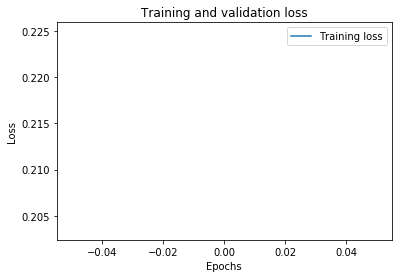

In [64]:
import matplotlib.pyplot as plt

loss = lstm_model_fit.history['loss']
# val_loss = lstm_model_fit.history['val_loss']
plt.plot(loss, label='Training loss')
# plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Prepare Test Data

In [65]:
loss

[0.21417275948999198]

In [0]:
print(test_data.shape)

(1000, 2)


In [0]:
#fill missing values from test
# test_data = test_data.fillna(' ')
# print(test_data.shape)
# test_data.isnull().sum()

(5200, 3)


title     0
author    0
text      0
dtype: int64

In [0]:
# tokenize test data
tokenizer.fit_on_texts(texts = test_data['Corpus'])
test_text = tokenizer.texts_to_sequences(texts = test_data['Corpus'])

In [0]:
test_text = pad_sequences(sequences = test_text, maxlen = max_features, padding = 'pre')

In [0]:
lstm_prediction = lstm_model.predict_classes(test_text)

In [0]:
prediction_outputs = pd.DataFrame({'Title':test_data.Title, 'Label':lstm_prediction})

In [0]:
prediction_outputs.shape

(1000, 2)

In [0]:
prediction_outputs.head()

,Title,Label
1,Albert Ernest Radford,0
2,Omar Saidou Tall,0
3,Paul Harteck,0
4,William John Tulloch,0
5,John Sutherland Black,0


#Check Accuracies

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
test_data['Label'] = 0

In [0]:
y_preds = list(prediction_outputs['Label'])
y_true = list(test_data['Label'])

In [0]:
accuracy_score(y_true,y_preds)

1.0

In [0]:
validation_data.head()

,Title,Corpus,Label
1,Robert Lightfoot (priest),Robert Henry Lightfoot ( 30 September 1883 – 2...,0
2,Jean Pierre Moquette,"Jean Pierre Moquette ( July 5 , 1856 – Februar...",0
3,John Willock,John Willock ( or Willocks or Willox ) ( c. 15...,0
4,David Packard,"David Packard ( PAK-ərd ; September 7 , 1912 –...",0
5,William F. Beck,"William Frederick Beck ( August 28 , 1904 – Oc...",0
